<a href="https://colab.research.google.com/github/guedhami/NLP-PROJECT/blob/main/projetNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn

In [ ]:
df = pd.read_csv("labeled_data.csv")

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
17401,17798,3,0,0,3,2,RT @SportsCenter: Peyton Manning's remarkable ...
17402,17799,3,0,0,3,2,RT @SportsCenter: Storybook ending in New York...
17403,17800,3,0,0,3,2,RT @SportsCenter: Yankees survive 9th-inning s...
17404,17801,3,0,0,3,2,"RT @SportsNation: So, Yanks have signed Brian ..."


In [ ]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,17406.000000,17406.000000,17406.000000,17406.000000,17406.000000,17406.000000
mean,8923.153625,3.233655,0.296220,2.384408,0.553028,1.105883
std,5141.664482,0.865593,0.653925,1.384797,1.118402,0.470800
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,4479.250000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,8945.500000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,13373.750000,3.000000,0.000000,3.000000,0.000000,1.000000
max,17802.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [ ]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

<Axes: >

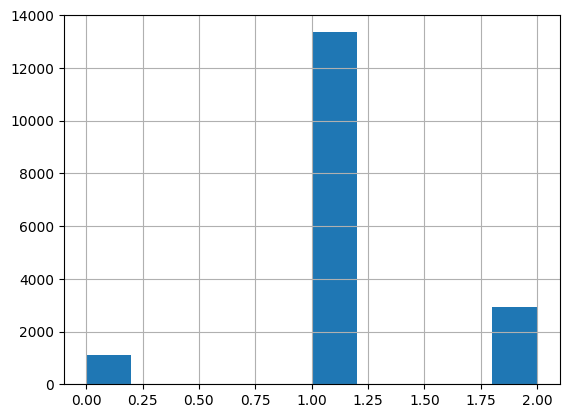

In [ ]:
df['class'].hist()

In [ ]:
tweets=df.tweet

In [ ]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:

tfidf = vectorizer.fit_transform(tweets).toarray()

vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


In [ ]:
#Get POS tags for tweets and save as a string

import nltk
# Download the resource with language specified
nltk.download('averaged_perceptron_tagger_eng')
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
print(tweet_tags[:10])

['. . . NN VBD DT NN DT NN NN VBD DT JJ NN NN JJ NN NN JJ JJ NN NN JJ NN NN IN JJ NN VBD DT NN VBP DT NN NN JJ NN NN NN VBZ DT NN NN VBP NN JJ NN NN NN JJ NN NN JJ JJ NN NN . DT NN NN DT NN DT NN DT JJ NN NN JJ NN NN JJ JJ NN VBZ DT NN WRB DT NN NN VBZ DT NN NN NN NN NN NN VBZ DT JJ NN NN JJ NN . . .', '. . . . . NN NN NN NN NN VBZ DT JJ NN NN NN NN NN . . . JJ NN VBD DT NN NN NN VBD DT NN NN NN NN NN JJ JJ NN NN VBP VBZ DT NN NN IN NN NN VBP NN NN NN NN NN NN VBZ DT JJ NN . .', '. . . . . . . NN NN VBZ DT JJ NN . . . . NN NN NN NN JJ NN NN NN NN NN JJ NN VBD DT NN NN VBP NN NN DT JJ NN NN NN NN NN VBD DT NN NN NN NN NN NN NN . UH NN JJ NN NN NN NN JJ NN JJ NN NN VBZ DT JJ NN NN NN VBP', '. . . . . . . . . NN NN NN NN NN NN NN NN NN NN NN VBP VBZ DT NN NN DT JJ NN NN', '. . . . . . . . . . . . . NN NN NN NN NN NN NN JJ VBP JJ NN JJ NN VBZ DT NN DT NN NN JJ NN NN IN NN NN VBP NN NN NN NN NN NN JJ NN IN NN NN VBP NN NN VBP NN NN NN NN VBZ DT NN NN NN NN VBD DT JJ NN NN NN NN NN VBP NN NN

In [ ]:
import nltk
from nltk import pos_tag
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=1,
    max_df=0.75,
    )

#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
# Use get_feature_names_out() instead of get_feature_names()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

In [ ]:
#Now get other features
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = preprocess(tweet) #Get text only

    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [ ]:
!pip install textstat
import textstat
feats = get_feature_array(tweets)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.0 MB/s eta 0:00:00


In [ ]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
M.shape

(17406, 4031)

In [ ]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

X = pd.DataFrame(M)
y = df['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

pipe = Pipeline(
    [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                penalty="l1", C=0.01, solver='liblinear'))), # Changed line: Added solver='liblinear'
    ('model', LogisticRegression(class_weight='balanced', penalty='l2'))])

param_grid = [{}]

# Modified line: Added shuffle=True to StratifiedKFold
grid_search = GridSearchCV(pipe, param_grid,
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_train),
                          verbose=2)

model = grid_search.fit(X_train, y_train)
y_preds = model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=  15.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=  11.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("logistic_regression_report:")
report = classification_report( y_test, y_preds )
print(report)

logistic_regression_report:
              precision    recall  f1-score   support

           0       0.22      0.62      0.33       219
           1       0.95      0.73      0.83      2683
           2       0.58      0.80      0.67       580

    accuracy                           0.74      3482
   macro avg       0.58      0.72      0.61      3482
weighted avg       0.84      0.74      0.77      3482



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Tokenization and padding
#tokenizer = nltk.word_tokenize # This line is not needed
X_tokens = [tokenize(t) for t in tweets]

# Create a word-to-index mapping
word_index = {word: index + 1 for index, word in enumerate(set(word for tokens in X_tokens for word in tokens))}

# Convert tokens to numerical indices
X_indexed = [[word_index[word] for word in tokens] for tokens in X_tokens]

# Pad sequences with numerical indices
X_padded = pad_sequences(X_indexed, padding='post', maxlen=100)  # Maxlen should be chosen based on your dataset

# Split data into train and test sets for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# LSTM Model
# Updated input_dim to reflect the size of the vocabulary
model_lstm = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=100),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(3, activation='softmax')  # Assuming 3 classes in the classification task
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32)

# Evaluate LSTM
y_preds_lstm = model_lstm.predict(X_test_lstm)
y_preds_lstm = y_preds_lstm.argmax(axis=-1)

print("LSTM Classification Report:")
print(classification_report(y_test_lstm, y_preds_lstm))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


436/436 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7548 - loss: 0.7103
Epoch 2/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7652 - loss: 0.6749
Epoch 3/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7681 - loss: 0.6698
Epoch 4/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7690 - loss: 0.6663
Epoch 5/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7679 - loss: 0.6707
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       219
           1       0.77      1.00      0.87      2683
           2       0.00      0.00      0.00       580

    accuracy                           0.77      3482
   macro avg       0.26      0.33      0.29      3482
weighted avg       0.59      0.77      0.67      3482



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import classification_report
import torch
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_llm = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Tokenizing the tweets
X_tokenized = tokenizer(tweets.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)

# Split data into train and test sets
X_train_llm, X_test_llm, y_train_llm, y_test_llm = train_test_split(X_tokenized['input_ids'], y, test_size=0.2, random_state=42)

# Convert y_train_llm and y_test_llm to PyTorch tensors
y_train_llm = torch.tensor(y_train_llm.values)
y_test_llm = torch.tensor(y_test_llm.values)

# Set up Trainer and TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,  # Enable mixed precision training (if your GPU supports it)
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    dataloader_num_workers=2,  # Enable data loading with multiple workers
)

# Create a custom data collator to handle TensorDataset
def custom_data_collator(features):
    # Assuming features is a list of tuples (input_ids, labels)
    input_ids = torch.stack([f[0] for f in features])
    labels = torch.stack([f[1] for f in features])
    return {'input_ids': input_ids, 'labels': labels}


# Create TensorDataset instances
train_dataset = TensorDataset(X_train_llm, y_train_llm)
eval_dataset = TensorDataset(X_test_llm, y_test_llm)

trainer = Trainer(
    model=model_llm,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_data_collator, # Use the custom data collator
)





/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Log in to Weights & Biases in Colab by pasting your API key
# Train bert model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
10,1.116500
20,1.000500
30,0.866300
40,0.737400
50,0.689600
60,0.717900
70,0.663100
80,0.717200
90,0.685000
100,0.566500


TrainOutput(global_step=2610, training_loss=0.3485695451612217, metrics={'train_runtime': 1159.4138, 'train_samples_per_second': 36.029, 'train_steps_per_second': 2.251, 'total_flos': 8861359795336944.0, 'train_loss': 0.3485695451612217, 'epoch': 2.998276852383688})

In [ ]:
trainer.save_model("bert_model")

In [ ]:
# Evaluate LLM
y_preds_llm = trainer.predict(eval_dataset)
y_preds_llm = y_preds_llm.predictions.argmax(axis=-1)

print("Bert Classification Report:")
print(classification_report(y_test_llm, y_preds_llm))

Bert Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.37      0.40       219
           1       0.93      0.95      0.94      2683
           2       0.89      0.86      0.88       580

    accuracy                           0.90      3482
   macro avg       0.75      0.73      0.74      3482
weighted avg       0.90      0.90      0.90      3482



In [ ]:
# Example of model comparison

# Store classification reports for each model
logistic_regression_report = classification_report(y_test, y_preds, output_dict=True) # Store Logistic Regression report
print(classification_report(y_test, y_preds))
lstm_classification_report = classification_report(y_test_lstm, y_preds_lstm, output_dict=True) # Store LSTM report
print(classification_report(y_test_lstm, y_preds_lstm))
llm_classification_report = classification_report(y_test_llm, y_preds_llm, output_dict=True) # Store LLM report
print(classification_report(y_test_llm, y_preds_llm))

results = {
    'Logistic Regression': logistic_regression_report,
    'LSTM': lstm_classification_report,
    'Bert': llm_classification_report
}

# Find the model with the highest accuracy
best_model = max(results, key=lambda model: results[model]['accuracy'])  # Find model with highest accuracy

print(f"The best model is {best_model}")

              precision    recall  f1-score   support

           0       0.22      0.62      0.33       219
           1       0.95      0.73      0.83      2683
           2       0.58      0.80      0.67       580

    accuracy                           0.74      3482
   macro avg       0.58      0.72      0.61      3482
weighted avg       0.84      0.74      0.77      3482

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       219
           1       0.77      1.00      0.87      2683
           2       0.00      0.00      0.00       580

    accuracy                           0.77      3482
   macro avg       0.26      0.33      0.29      3482
weighted avg       0.59      0.77      0.67      3482

              precision    recall  f1-score   support

           0       0.43      0.37      0.40       219
           1       0.93      0.95      0.94      2683
           2       0.89      0.86      0.88       580

    accuracy        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

<Axes: xlabel='Predicted categories', ylabel='True categories'>

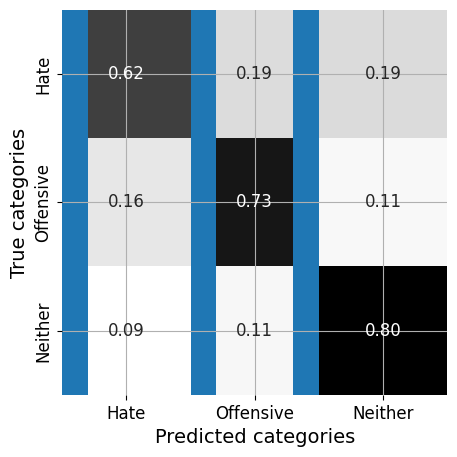

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)


#plt.savefig('confusion.pdf')
#True distribution
y.hist()

<Axes: >

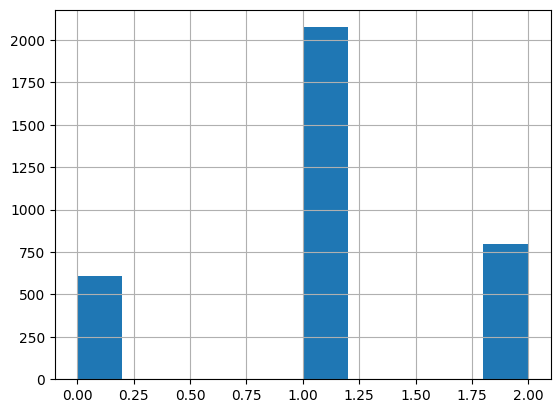

In [ ]:
pd.Series(y_preds).hist()

In [ ]:
# prompt: can we know do streamlit

!pip install streamlit
!pip install pyngrok
!ngrok authtoken 2pwqJD0Xp75hVL4sBPQKal3HkAF_71dGB6bKu6G18Esrxj31M






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import streamlit as st

In [ ]:
%%writefile app.py
import streamlit as st
from transformers import BertTokenizer, BertForSequenceClassification
import torch

st.title("Hate Speech Detection App")

# Load the pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set the device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_hate_speech(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get predicted class (argmax on the logits)
    predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

# Get user input from the Streamlit interface
user_input = st.text_input("Enter a tweet:")

# Ensure proper indentation for the button and prediction flow
if st.button('Check Hate Speech'):
    if user_input:
        # Call the prediction function and display the result
        prediction = predict_hate_speech(user_input)

        if prediction == 1:
            st.write("The tweet is classified as Hate Speech!")
        else:
            st.write("The tweet is not Hate Speech.")
    else:
        st.write("Please enter a tweet to classify.")


Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Set up a tunnel to the Streamlit app
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at {public_url}")

# Run Streamlit app
!streamlit run app.py

Streamlit app is live at NgrokTunnel: "https://e887-34-83-49-112.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.83.49.112:8501

2024-12-11 10:41:21.985433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 10:41:22.010012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 10:41:22.017345: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 10:41:23.573686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38